In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
WORKDIR = os.getcwd()

In [2]:
# Reading air quality sensor data obtained from CPCB platform.

import pandas as pd

# Locations where CPCB air quality sensors are present and are collecting ground truth data

locations = [
    'Mandir Marg, Delhi - DPCC',
    'Chandni Chowk, Delhi - IITM',    
    'Loni, Ghaziabad - UPPCB'
]

aq_sensor_data = pd.read_excel(WORKDIR+'/datasets/aqi_sensor_data.xlsx', index_col=0)  
print(aq_sensor_data)


                                                    datetime    aqi
name                                                               
Chandni Chowk, Delhi - IITM   Thursday, 01 Apr 2021 03:00 PM  222.0
Chandni Chowk, Delhi - IITM     Friday, 02 Apr 2021 03:00 PM  228.0
Chandni Chowk, Delhi - IITM    Tuesday, 06 Apr 2021 03:00 PM  321.0
Chandni Chowk, Delhi - IITM  Wednesday, 07 Apr 2021 03:00 PM  314.0
Chandni Chowk, Delhi - IITM     Friday, 09 Apr 2021 03:00 PM  197.0
Chandni Chowk, Delhi - IITM   Saturday, 10 Apr 2021 03:00 PM  216.0
Chandni Chowk, Delhi - IITM     Sunday, 11 Apr 2021 03:00 PM  234.0
Chandni Chowk, Delhi - IITM     Monday, 12 Apr 2021 03:00 PM  268.0
Chandni Chowk, Delhi - IITM     Monday, 19 Apr 2021 03:00 PM   90.0
Chandni Chowk, Delhi - IITM     Friday, 23 Apr 2021 03:00 PM  248.0
Chandni Chowk, Delhi - IITM   Saturday, 24 Apr 2021 03:00 PM  203.0
Chandni Chowk, Delhi - IITM     Sunday, 25 Apr 2021 03:00 PM  167.0
Chandni Chowk, Delhi - IITM     Monday, 26 Apr 2

In [3]:
# Observations from the data

# Delhi lockdown dates in 2021 from April 19 onwards
# https://www.thehindu.com/news/cities/Delhi/delhi-lockdown-extended-till-may-31/article34625962.ece

# The above collected data is for the month of April 2021 for three stations.

# In Chandni Chowk we observe a sharp decrease in the AQI from 19th April 2021.
# In Mandir Marg, we observe a sharp decrease in 22nd April and then it rises back again.
# In Mandir Marg, we observe higher AQI levels in the lockdown period.

In [4]:
# Air quality sensor locations of the three ground stations

import geopandas as gpd
gdf = gpd.read_file(WORKDIR+'/datasets/aq_stations.geojson')
gdf.head()

,id,name,geometry
0,1,"Mandir Marg, Delhi - DPCC",POINT (77.20106 28.63643)
1,2,"Chandni Chowk, Delhi - IITM",POINT (77.22723 28.65676)
2,3,"Loni, Ghaziabad - UPPCB",POINT (77.27879 28.75729)


<AxesSubplot:>

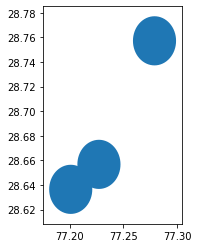

In [5]:
# Region of interest: Buffer of 0.02 degrees is taken around the ground sensors.
# Assumption: Near things affect more than distant things.

gdf['geometry'] = gdf['geometry']
gdf['geometry'] = gdf['geometry'].buffer(0.02)

gdf.plot()

In [6]:
# Mobility can be one of the factors for increase in the AQI levels.
# So one of the parameters can be density of railways and roadways.
# Fetching Highways and Railways Data

hr_gpd = gpd.read_file(WORKDIR+'/datasets/highways_railways.geojson')

In [7]:
#Computing highway and railway line density
for i in range(0, len(locations)):
    a1 = gdf.iloc[i]    
    road_density = hr_gpd['geometry'].intersection(a1['geometry']).length
    print('Road Density Values')
    print(a1['name']+'='+str(road_density.sum()))


Road Density Values
Mandir Marg, Delhi - DPCC=2.483152797382156
Road Density Values
Chandni Chowk, Delhi - IITM=2.266370100077988
Road Density Values
Loni, Ghaziabad - UPPCB=0.07730455236204287


In [8]:
# Observations from the Road Density Values

# Mandir Marg has the maximum highway and railway density in the region.
# Loni, Ghaziabad has the least highway and railway density in the region.

In [9]:
# Forest cover is another important indicator for AQI levels.
# Loading Forest Layer

for_gpd = gpd.read_file(WORKDIR+'/datasets/forests.geojson')
for_gpd['geometry'] = for_gpd['geometry'].buffer(0)

In [10]:
#Computing Forest density
for i in range(0, len(locations)):
    a1 = gdf.iloc[i]
    forest_density = for_gpd['geometry'].intersection(a1['geometry']).area
    print('Forest density')
    print(a1['name']+'='+str(forest_density.sum()))

Forest density
Mandir Marg, Delhi - DPCC=0.00024191357230874682
Forest density
Chandni Chowk, Delhi - IITM=3.0886444917354208e-06
Forest density
Loni, Ghaziabad - UPPCB=0.0


In [11]:
# Observations from the Forest Density Analysis

# Mandir Marg has the highest forest density cover.
# Loni Ghaziabad has the least forest density cover.

In [12]:
# Industries are another important indicator for the AQI levels.
# Density of industries is another parameter for the analysis.
# Loading Industries Layer

ind_gpd = gpd.read_file(WORKDIR+'/datasets/industrial.geojson')
ind_gpd['geometry'] = ind_gpd['geometry'].buffer(0)

In [13]:
#Computing Industrial density
for i in range(0, len(locations)):
    a1 = gdf.iloc[i]
    print('Industry density')
    ind_density = ind_gpd['geometry'].intersection(a1['geometry']).area
    print(a1['name']+'='+str(ind_density.sum()))

Industry density
Mandir Marg, Delhi - DPCC=2.64257285501008e-06
Industry density
Chandni Chowk, Delhi - IITM=0.0
Industry density
Loni, Ghaziabad - UPPCB=0.0


In [14]:
# Observations from the industries layer

# Mandir marg has highest density of industries among the other two regions.